In [77]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
from config import *
from data import JSONLDataset, ImageDataset, ImageCaptionDataset, CLASS_MAP, get_image_UIDs, crop_image_preprocess_text_batch
from path import SPLITS_PATH
from models.vl_encoders import VLE_REGISTRY, VLEncoder
from viz import print_layer_numel

from torch import nn
from torchvision.models import segmentation as segmodels
from functools import partial
from torchvision.transforms._presets import SemanticSegmentation
import torchvision.transforms.v2 as T
from torch.utils.data import DataLoader
from collections import OrderedDict

---

In [88]:
from torchvision.transforms.functional import to_pil_image

In [95]:
offset = ...

captions_ds = JSONLDataset(Path('/home/olivieri/exp/data/data_gen/VOC2012/train_no_aug/captions.jsonl'))
images_ds = ImageDataset(Path('/home/olivieri/exp/data/data_gen/VOC2012/train_no_aug/images'))

In [120]:
img_cap_ds = ImageCaptionDataset(
    images_ds,
    captions_ds
)

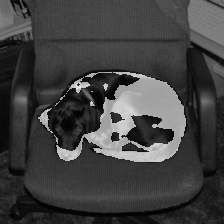

{'img_uid': '2007_000063', 'pos_class': 12, 'content': 'The prediction mask of the DOG region is quite rough and imprecise. It misses several parts of the ground truth DOG, especially on the left side and around the head. The boundary of the predicted DOG is also quite irregular and less defined compared to the ground truth.'}


In [130]:
img, cap = img_cap_ds[3]
display(to_pil_image(img))
print(cap)

In [39]:
vle: VLEncoder = VLE_REGISTRY.get("flair", device=CONFIG['device'])
vle.set_vision_trainable_params('visual_proj')
print_layer_numel(vle.model, print_only_total=True, only_trainable=True)

visual_proj.attn.in_proj_weight: 786,432
visual_proj.attn.in_proj_bias : 1,536
visual_proj.attn.out_proj.weight: 262,144
visual_proj.attn.out_proj.bias: 512
visual_proj.ln_q.weight       : 512
visual_proj.ln_q.bias         : 512
visual_proj.ln_k.weight       : 512
visual_proj.ln_k.bias         : 512
visual_proj.ln_v.weight       : 512
visual_proj.ln_v.bias         : 512
Total: 1,053,696


In [40]:
segnet = segmodels.lraspp_mobilenet_v3_large(weights=None, weights_backbone=None).to(CONFIG["device"])
segnet.load_state_dict(torch.load(TORCH_WEIGHTS_CHECKPOINTS / ("lraspp_mobilenet_v3_large-full-pt" + ".pth")))
segnet.requires_grad_(False)
segnet.eval();

In [41]:
center_crop_fn = T.CenterCrop(CONFIG['seg']['image_size'])

segnet_preprocess_fn = partial(SemanticSegmentation, resize_size=CONFIG['seg']['image_size'])()

collate_fn = partial(
    crop_image_preprocess_text_batch,
    crop_fn=center_crop_fn,
    preprocess_text_fn=vle.preprocess_texts
)

image_caption_dl = DataLoader(
    image_caption_ds,
    batch_size=CONFIG["seg"]["batch_size"],
    shuffle=False,
    generator=TORCH_GEN.clone_state(),
    collate_fn=collate_fn,
)

In [42]:
criterion = ...

lr = 1e-4
optimizer = torch.optim.AdamW(vle.model.parameters(), lr=lr)

for step, (scs_img, gts, text) in enumerate(image_caption_dl):
        
        with torch.inference_mode():

            print("...")

            if segnet_preprocess_fn:
                scs = segnet_preprocess_fn(scs_img)

            scs = scs.to(CONFIG["device"])
            gts = gts.to(CONFIG["device"]) # shape [N, H, W]

            logits = segnet(scs)
            logits: torch.Tensor = logits["out"] if isinstance(logits, OrderedDict) else logits # shape [N, C, H, W]
            prs = logits.argmax(dim=1, keepdim=True)
            scs_img = (scs_img*255).to(torch.uint8)

            display(scs_img[0])

            break

        optimizer.zero_grad()
        vle.encode_and_project()

[{'img_idx': 0, 'content': 'The prediction mask of the AEROPLANE region is quite fragmented and incomplete. Large portions of the fuselage are missing, and the tail section is also not fully captured. The boundaries are very irregular and do not align well with the ground truth.'}, {'img_idx': 1, 'content': 'The prediction mask for the PERSON class is significantly incomplete. It only captures a small portion of the ground truth PERSON region, missing the upper body and head. The boundaries are also quite rough and do not accurately reflect the shape of the person.'}, {'img_idx': 2, 'content': "The prediction mask for the TVMONITOR region is quite accurate overall, capturing most of the object. However, the boundary of the TVMONITOR is quite jagged and less defined compared to the ground truth. There's a noticeable difference in the smoothness of the edges, particularly on the right side of the monitor."}, {'img_idx': 3, 'content': 'The prediction mask for the CHAIR region is quite rou

AttributeError: 'dict' object has no attribute 'find'